## Import Packages

In [51]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score

import cv2

from keras import backend as K
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tf_explain.core.grad_cam import GradCAM

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

import util

## Load Data set

For the purpose of this project, we will use this dataset that you can find more simply [here](https://nihcc.app.box.com/v/ChestXray-NIHCC/folder) and we will apply the elements of the 1st AI for medicine specialization course on medical diagnostics. 
This dataset of 40GB+ has already been properly separated by avoiding the "data leakage problem".
Each image in the dataset was labeled according to 14 different pathological conditions.

In [2]:
train_data=pd.read_csv("LongTailCXR/nih-cxr-lt_single-label_train.csv")
test_data=pd.read_csv("LongTailCXR/nih-cxr-lt_single-label_test.csv")
val_data=pd.read_csv("LongTailCXR/nih-cxr-lt_single-label_balanced-val.csv")

For computational reasons, we have selected only a part (31GB) of the initial data

In [3]:
train_data=train_data[train_data["subject_id"]<=20943]
test_data=test_data[test_data["subject_id"]<=20943]
val_data=val_data[val_data["subject_id"]<=20943]

## EDA

In [4]:

train_data

,id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumoperitoneum,Pneumomediastinum,Subcutaneous Emphysema,Tortuous Aorta,Calcification of the Aorta,No Finding,subject_id
0,00000001_000.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,00000002_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
2,00000005_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5
3,00000005_001.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5
4,00000005_002.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51411,00020940_001.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,20940
51412,00020941_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20941
51413,00020942_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,20942
51414,00020942_001.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,20942


In [5]:
val_data

,id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumoperitoneum,Pneumomediastinum,Subcutaneous Emphysema,Tortuous Aorta,Calcification of the Aorta,No Finding,subject_id
0,00003109_004.png,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3109
1,00003109_006.png,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3109
2,00003109_008.png,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3109
3,00018657_001.png,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,18657
4,00018657_008.png,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,18657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,00004425_006.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4425
290,00004425_007.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4425
291,00013138_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,13138
292,00013138_001.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,13138


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51416 entries, 0 to 51415
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   id                          51416 non-null  object
 1   Atelectasis                 51416 non-null  int64 
 2   Cardiomegaly                51416 non-null  int64 
 3   Consolidation               51416 non-null  int64 
 4   Edema                       51416 non-null  int64 
 5   Effusion                    51416 non-null  int64 
 6   Emphysema                   51416 non-null  int64 
 7   Fibrosis                    51416 non-null  int64 
 8   Hernia                      51416 non-null  int64 
 9   Infiltration                51416 non-null  int64 
 10  Mass                        51416 non-null  int64 
 11  Nodule                      51416 non-null  int64 
 12  Pleural_Thickening          51416 non-null  int64 
 13  Pneumonia                   51416 non-null  in

In [7]:
print(f" Number of patients  : {train_data['subject_id'].count()}")


 Number of patients  : 51416


In [8]:
print(f" Unique ID : {train_data['subject_id'].value_counts().shape[0]}")

 Unique ID : 15904


In [9]:
train_data['subject_id'].value_counts()

13670    117
6271      98
1836      85
4808      78
4006      78
        ... 
9174       1
9176       1
9179       1
9180       1
20943      1
Name: subject_id, Length: 15904, dtype: int64

In [10]:
#Check for any null(NaN) values
train_data.isnull().sum()

id                            0
Atelectasis                   0
Cardiomegaly                  0
Consolidation                 0
Edema                         0
Effusion                      0
Emphysema                     0
Fibrosis                      0
Hernia                        0
Infiltration                  0
Mass                          0
Nodule                        0
Pleural_Thickening            0
Pneumonia                     0
Pneumothorax                  0
Pneumoperitoneum              0
Pneumomediastinum             0
Subcutaneous Emphysema        0
Tortuous Aorta                0
Calcification of the Aorta    0
No Finding                    0
subject_id                    0
dtype: int64

'c=train_data.drop(["id","subject_id","No Finding"],axis=1).columns\nfor i in c:\n  print(train_data[i].value_counts() )\n  print("\n")\nplt.tight_layout()'

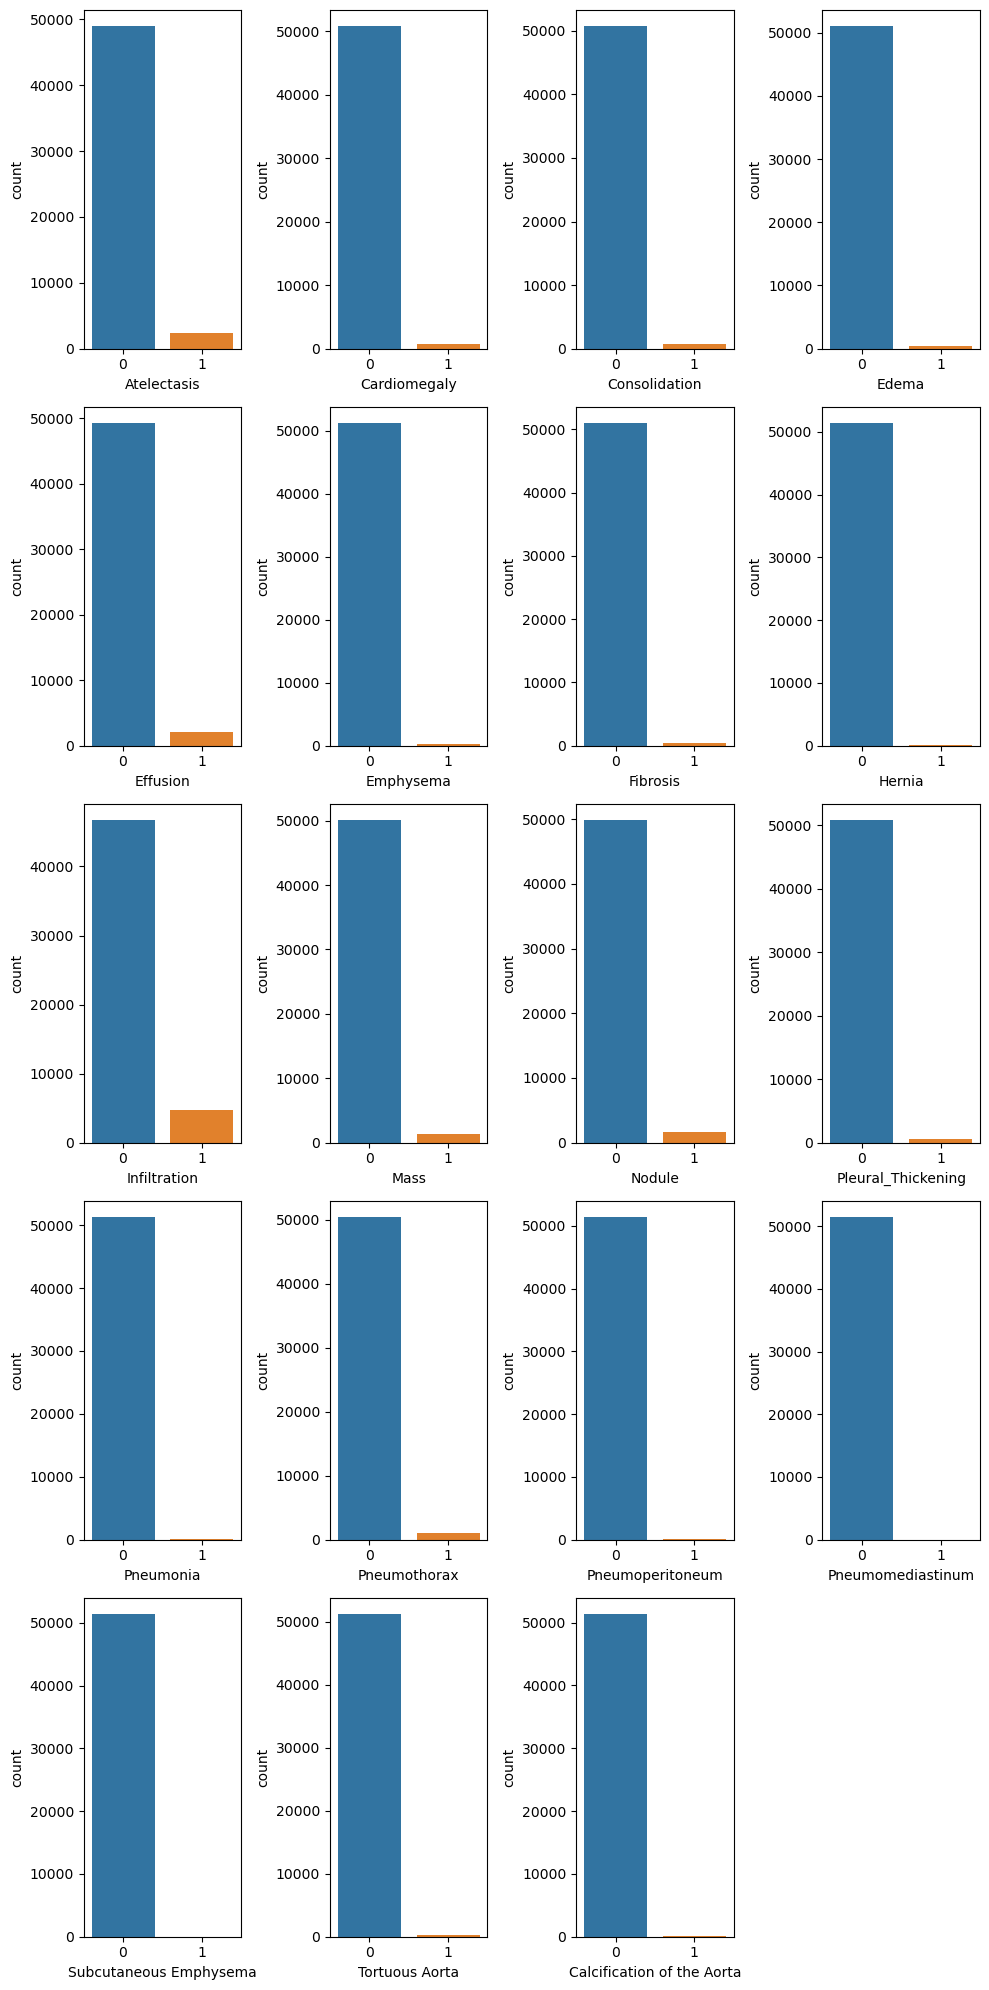

In [11]:
c=train_data.drop(["id","subject_id","No Finding"],axis=1).columns
plt.figure(figsize=(10,20))
for i , j in enumerate(c) :
    plt.subplot(5, 4,i+1)
    sn.countplot(x=train_data[j])

plt.tight_layout() 
"""c=train_data.drop(["id","subject_id","No Finding"],axis=1).columns
for i in c:
  print(train_data[i].value_counts() )
  print("\n")
plt.tight_layout()"""

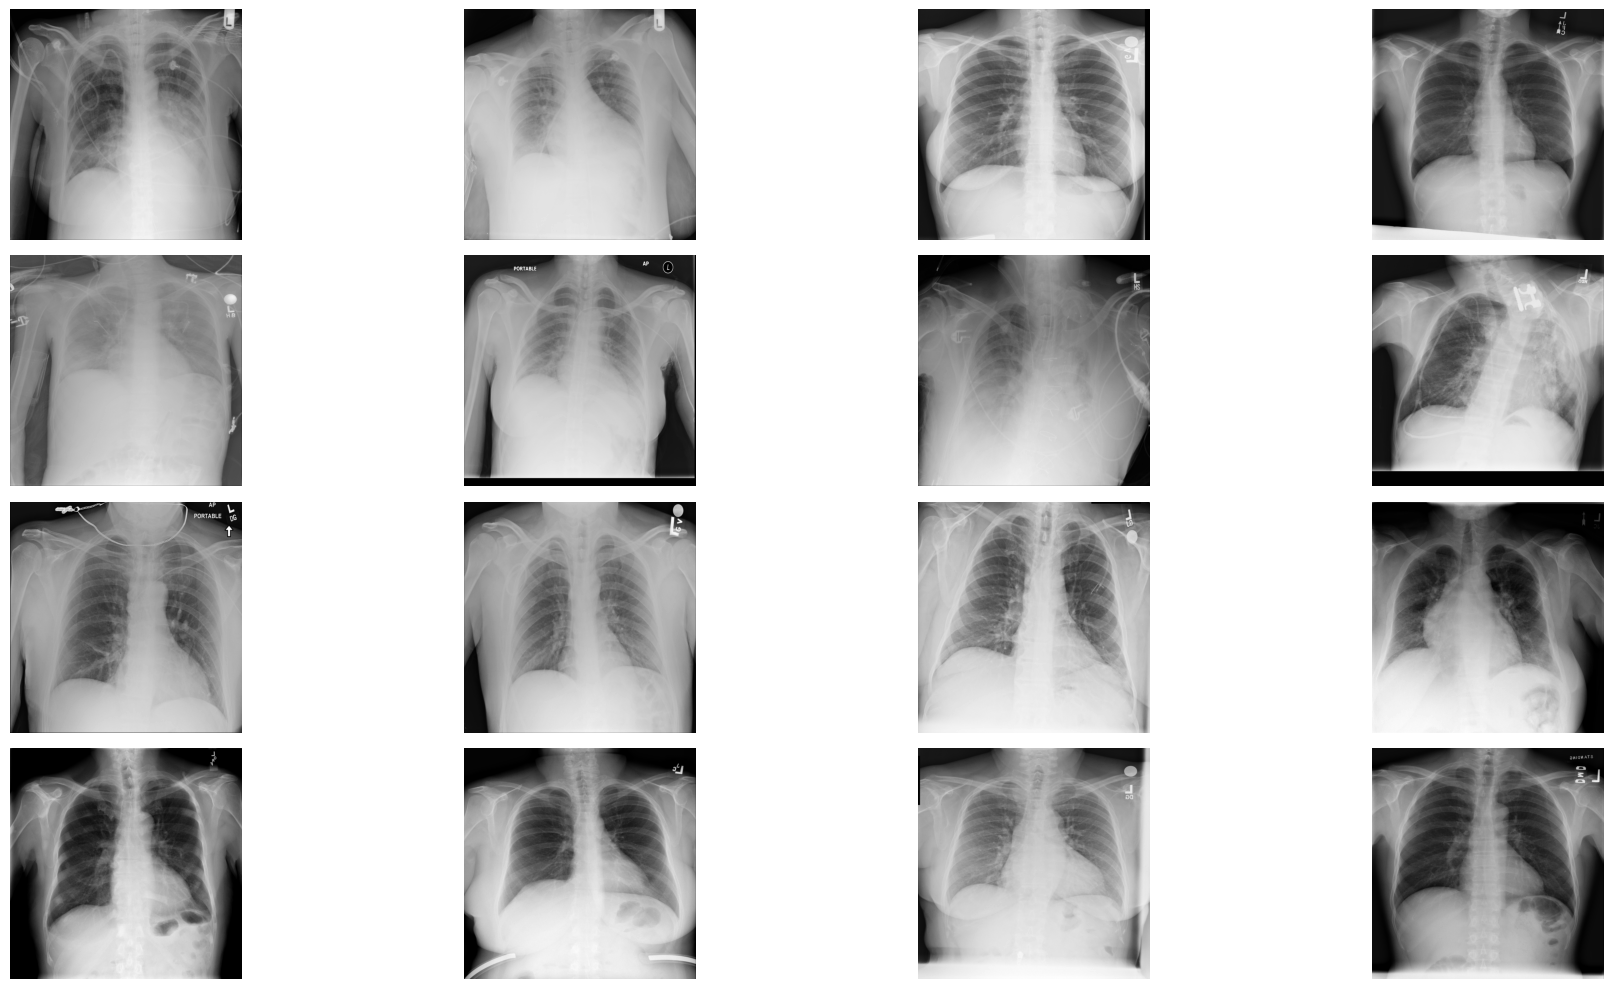

In [12]:
#Plot random images
images = train_data['id'].values
random_images = [np.random.choice(images) for i in range(16)]
img_dir = 'LongTailCXR/images/'

plt.figure(figsize=(20,10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()    

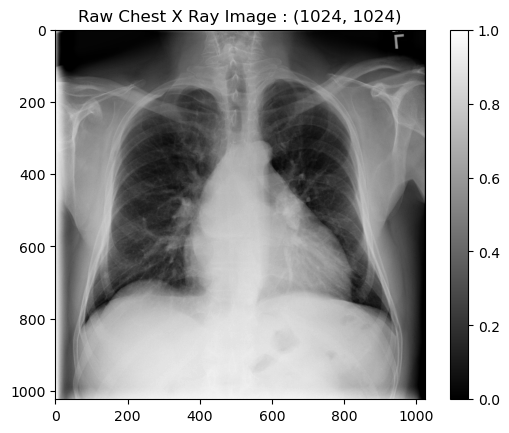

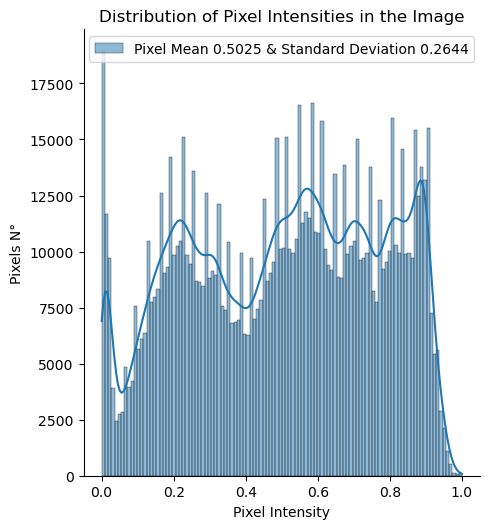

In [13]:
 
def plot_image_distribution(sample_img):
    raw_image = plt.imread(os.path.join(img_dir, sample_img))
    plt.imshow(raw_image, cmap='gray')
    plt.colorbar()
    plt.title(f'Raw Chest X Ray Image : {raw_image.shape}')


    #A histogram of the distribution of the pixels
    sn.displot(raw_image.ravel(), 
                 label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}', kde=True)
    plt.legend(loc='upper center')
    plt.title('Distribution of Pixel Intensities in the Image')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Pixels N°')
    
plot_image_distribution(train_data.id[0])

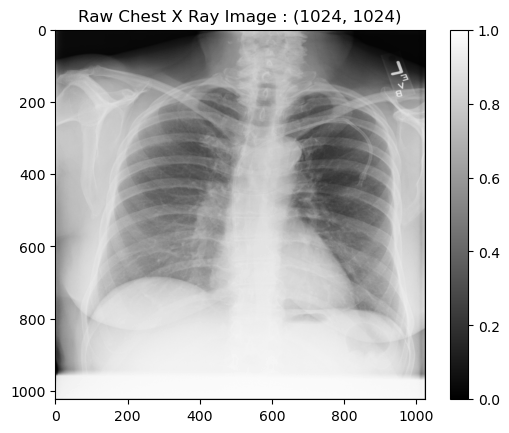

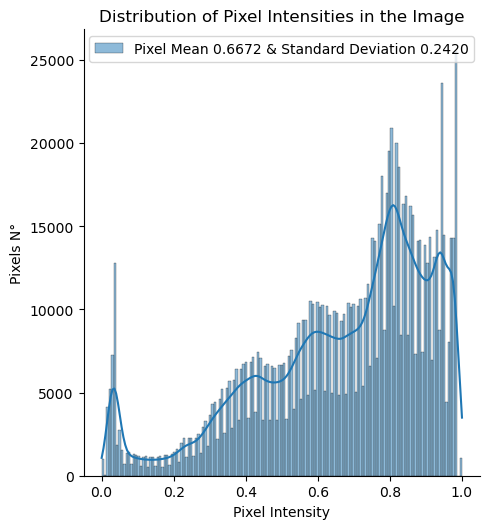

In [14]:
plot_image_distribution(train_data.id[2])

## Preprocessing

In [15]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator


def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="id", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    #it is important to return also data_sample to this for having the same normalization parameters in gradcam
    return valid_generator, test_generator , data_sample

In [16]:
labels = list(c)

In [17]:
IMAGE_DIR = "LongTailCXR/images/"
train_generator = get_train_generator(train_data, IMAGE_DIR, "id", labels)
val_generator, test_generator , data_sample= get_test_and_valid_generator(val_data, test_data, train_data, IMAGE_DIR, "id", labels)

getting train generator...
Found 51416 validated image filenames.
getting train and valid generators...
Found 51416 validated image filenames.
Found 248 validated image filenames.
Found 15641 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 320 pixels width and 320 pixels height
The maximum pixel value is 2.6775 and the minimum is -2.7327
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


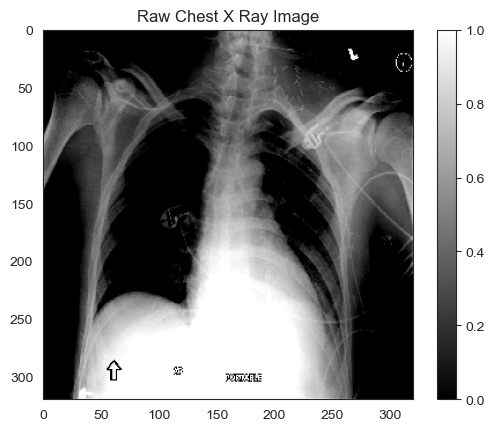

In [18]:
# Plot a processed image
sn.set_style("white")
generated_image, label = train_generator.__getitem__(1)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

##  Model Development and Training

we will use a pre-trained DenseNet121 model on imagenet which we can load directly from Keras ,and fine tuned by adding two layers on top of it and training it on our Train dataset 

In [19]:
# create the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)



In [20]:

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [21]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                     

In [22]:
len(base_model.layers)

427

In [23]:
conv2D_layers = [layer for layer in base_model.layers 
                if str(type(layer)).find('Conv2D') > -1]

In [24]:
len(conv2D_layers)

120

In [25]:
# define the callbacks
checkpoint = ModelCheckpoint('model_weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=15, mode='min', verbose=1)


model = Model(inputs=base_model.input, outputs=predictions)
                                       



In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                         

#### Dealing with Class Imbalance
For Dealing with Class Imbalance , we will use cunstom Loss by applying these weightings the positive and negative labels within each class in order to have the same aggregate contribution to the loss function

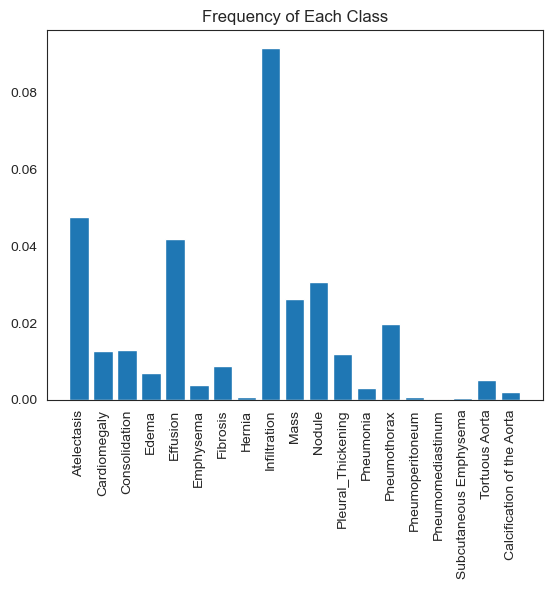

In [27]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [222]:
# Don't use these functions 
"""def calculating_class_weights(y_true):
    from sklearn.utils.class_weight import compute_class_weight
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight(class_weight ='balanced',classes = [0.,1.], y = y_true[:, i])
    return weights

def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
calculating_class_weights(np.array(train_data[labels]))"""

"def calculating_class_weights(y_true):\n    from sklearn.utils.class_weight import compute_class_weight\n    number_dim = np.shape(y_true)[1]\n    weights = np.empty([number_dim, 2])\n    for i in range(number_dim):\n        weights[i] = compute_class_weight(class_weight ='balanced',classes = [0.,1.], y = y_true[:, i])\n    return weights\n\ndef get_weighted_loss(weights):\n    def weighted_loss(y_true, y_pred):\n        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)\n    return weighted_loss\ncalculating_class_weights(np.array(train_data[labels]))"

In [29]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [30]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos


array([0.04741715, 0.01260308, 0.01295317, 0.00692391, 0.04175743,
       0.00385094, 0.00882994, 0.00064182, 0.09166407, 0.02619807,
       0.03067139, 0.01190291, 0.00303407, 0.01977984, 0.00075852,
       0.0001167 , 0.00044733, 0.00507624, 0.00184767])

In [31]:
len(freq_pos)

19

In [32]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Tensor): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0


        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class
            y_true_float = tf.cast(y_true, tf.float32) # Convert y_true to float32
            loss_pos = -1 * K.mean(pos_weights[i] * y_true_float[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true_float[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        
        return loss
    

    return weighted_loss

In [33]:
pos_weights = freq_neg
neg_weights = freq_pos

In [34]:
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))  
history = model.fit(train_generator, validation_data=val_generator, steps_per_epoch=100, validation_steps=25, epochs=25,
                              callbacks=[checkpoint, early_stop])

Epoch 1/25
100/100 [==============================] - ETA: 0s - loss: 0.5382 
Epoch 1: val_loss improved from inf to 10.16387, saving model to model_weights.h5
100/100 [==============================] - 1491s 14s/step - loss: 0.5382 - val_loss: 10.1639
Epoch 2/25
100/100 [==============================] - ETA: 0s - loss: 0.4893 
Epoch 2: val_loss improved from 10.16387 to 4.56145, saving model to model_weights.h5
100/100 [==============================] - 1413s 14s/step - loss: 0.4893 - val_loss: 4.5614
Epoch 3/25
100/100 [==============================] - ETA: 0s - loss: 0.4930 
Epoch 3: val_loss improved from 4.56145 to 3.64564, saving model to model_weights.h5
100/100 [==============================] - 1442s 14s/step - loss: 0.4930 - val_loss: 3.6456
Epoch 4/25
100/100 [==============================] - ETA: 0s - loss: 0.4532 
Epoch 4: val_loss improved from 3.64564 to 1.50566, saving model to model_weights.h5
100/100 [==============================] - 1442s 14s/step - loss: 0.4532 

In [35]:
model.load_weights("./model_weights.h5")

In [36]:
predicted_vals = model.predict(test_generator, steps = len(test_generator))

1956/1956 [==============================] - 4663s 2s/step


In [ ]:
"""# Get a batch of images and corresponding labels from the test generator
x_test, y_test = next(test_generator)

# Get the corresponding predicted labels from predicted_vals
y_pred = predicted_vals[:len
(x_test)]

# Choose an image index to plot
img_idx = 0

# Plot the image and its prediction
plt.imshow(x_test[img_idx])
plt.title(f"Predicted labels: {np.round(y_pred[img_idx], decimals=2)}\nTrue labels: {y_test[img_idx]}")
plt.axis("off")
plt.show()"""

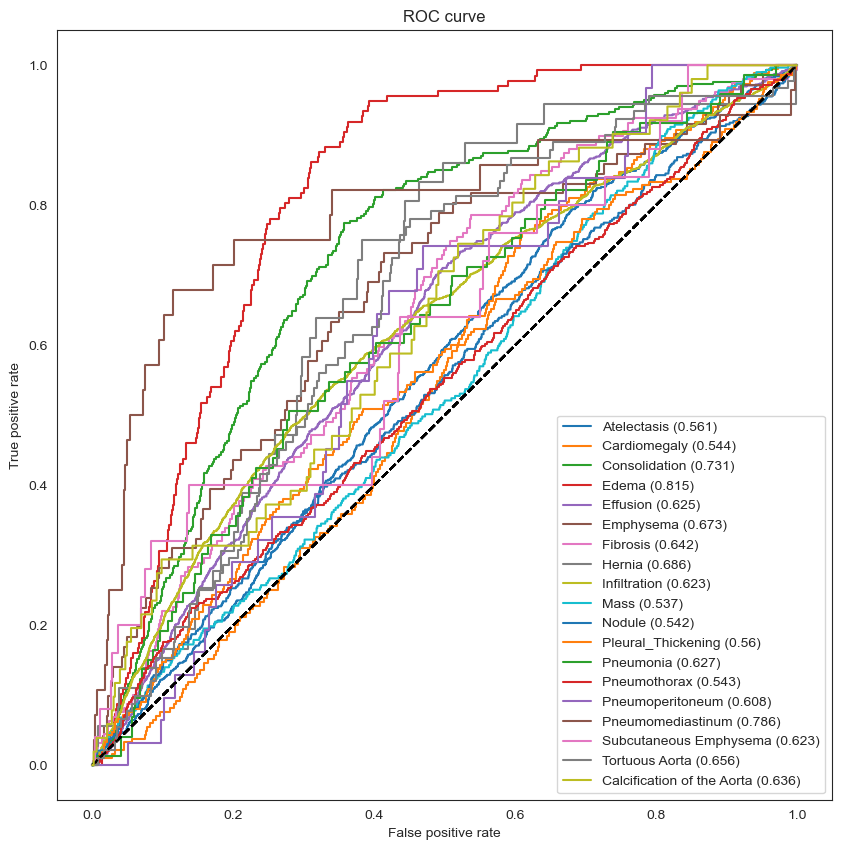

In [38]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

In [39]:
y=test_generator.labels

For this problem, I display all the metrics classically with a threshold of 0.5. Then I could have considered the AUC as a comparison metric but I not only want to have better class predictions (so forget the AUC) but I consider that it is especially important to minimize the False Negatives (maximize the RECALL or True Positive Rate (TPR)). This objective is achieved for a given threshold. 

To do this, from the ROC curve, we obtain the TPR and FPR the corresponding threshold. A function has been built to find the threshold corresponding to a maximum TPR while preferring a minimum FPR. Obviously this is applied to have the optimal threshold for each label. These thresholds are recorded and will be used to get the class prediction of a given image. 

In [229]:
def fx (tpr,fpr):
    
    tpr_c=tpr.copy()
    fpr_c=fpr.copy()
    c=max(tpr_c)
    for i in range(len(tpr_c)) :
        if tpr_c[i] < c :
            tpr_c[i]=0
            
    for i in range(len(fpr_c)) :
        if i not in np.where((fpr_c==c).any()) :
            fpr_c[i]=0
            
    return np.argmax(tpr_c-fpr_c)

In [228]:

t = np.array([0, 0, 1, 1])
scores = np.array([0.1, 0.8, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(t, scores, pos_label=1)
print(thresholds)
print(f'fpr {fpr}')
print(f'tpr {tpr}')
print(f'indice of best threshold : {fx(tpr, fpr)}') 

[1.8  0.8  0.35 0.1 ]
fpr [0.  0.5 0.5 1. ]
tpr [0.  0.5 1.  1. ]
indice of best threshold : 2


In [221]:

def get_performance_metrics(y_true, y_pred, class_labels,thr=0.5):
    
    y_pred_prob=y_pred
    y_pred=(np.array(y_pred) > thr).astype(int)
    cm_list = []
    acc_list = []
    prev_list = []
    sens_list = []
    spec_list = []
    ppv_list = []
    npv_list = []
    auc_list = []
    f1_list = []
    thresh_list = []
    
    # Loop over all labels
    for i, label in enumerate(class_labels):
        
        # Compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true[:, i], y_pred[:, i]).ravel()
        cm_list.append([tp, tn, fp, fn])
        
        # Compute performance metrics
        acc = accuracy_score(y_true[:, i], y_pred[:, i])
        acc_list.append(acc)
        
        prev = (tp + fn) / (tp + tn + fp + fn)
        prev_list.append(prev)
        
        sens = tp / (tp + fn)
        sens_list.append(sens)
        
        spec = tn / (tn + fp)
        spec_list.append(spec)
        
        ppv = tp / (tp + fp)
        ppv_list.append(ppv)
        
        npv = tn / (tn + fn)
        npv_list.append(npv)
        
        fpr, tpr, thresh = roc_curve(y_true[:, i], y_pred_prob[:, i])
        auc = roc_auc_score(y_true[:, i], y_pred_prob[:, i])
        auc_list.append(auc)
        
        f1 = f1_score(y_true[:, i], y_pred[:, i])
        f1_list.append(f1)
        
        thresh_list.append(thr)
        
    
    # Construct dataframe
    df = pd.DataFrame(data=cm_list, columns=['TP', 'TN', 'FP', 'FN'], index=class_labels)
    df['Accuracy'] = acc_list
    df['Prevalence'] = prev_list
    df['Sensitivity / Recall'] = sens_list
    df['Specificity'] = spec_list
    df['PPV / Precision'] = ppv_list
    df['NPV'] = npv_list
    df['AUC'] = auc_list
    df['F1'] = f1_list
    df['Threshold'] = thresh_list
    
    return df



def get_performance_metrics_with_best_threshold(y_true, y_pred, class_labels):
    

    cm_list = []
    acc_list = []
    prev_list = []
    sens_list = []
    spec_list = []
    ppv_list = []
    npv_list = []
    auc_list = []
    f1_list = []
    thresh_list = []
    
    # Loop over all labels
    for i, label in enumerate(class_labels):
        
        fpr, tpr, thresh = roc_curve(y_true[:, i], y_pred[:, i])
        auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        auc_list.append(auc)
        
        thr=thresh[fx(tpr, fpr)]
        y_pred_i=(np.array(y_pred[:, i]) >= thr).astype(int)
        # Compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true[:, i], y_pred_i).ravel()
        cm_list.append([tp, tn, fp, fn])
        
        # Compute performance metrics
        acc = accuracy_score(y_true[:, i], y_pred_i)
        acc_list.append(acc)
        
        prev = (tp + fn) / (tp + tn + fp + fn)
        prev_list.append(prev)
        
        sens = tp / (tp + fn)
        sens_list.append(sens)
        
        spec = tn / (tn + fp)
        spec_list.append(spec)
        
        ppv = tp / (tp + fp)
        ppv_list.append(ppv)
        
        npv = tn / (tn + fn)
        npv_list.append(npv)
        
        
        
        f1 = f1_score(y_true[:, i], y_pred_i)
        f1_list.append(f1)
        
        thresh_list.append(thr)
        
    
    # Construct dataframe
    df = pd.DataFrame(data=cm_list, columns=['TP', 'TN', 'FP', 'FN'], index=class_labels)
    df['Accuracy'] = acc_list
    df['Prevalence'] = prev_list
    df['Sensitivity / Recall'] = sens_list
    df['Specificity'] = spec_list
    df['PPV / Precision'] = ppv_list
    df['NPV'] = npv_list
    df['AUC'] = auc_list
    df['F1'] = f1_list
    df['Threshold'] = thresh_list
    
    return df





In [220]:
get_performance_metrics(y, predicted_vals, labels)

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_10412\3424319347.py:41: RuntimeWarning: invalid value encountered in longlong_scalars
  npv = tn / (tn + fn)
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_10412\3424319347.py:41: RuntimeWarning: invalid value encountered in longlong_scalars
  npv = tn / (tn + fn)
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_10412\3424319347.py:41: RuntimeWarning: invalid value encountered in longlong_scalars
  npv = tn / (tn + fn)


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity / Recall,Specificity,PPV / Precision,NPV,AUC,F1,Threshold
Atelectasis,64,13760,1185,632,0.883831,0.044498,0.091954,0.920709,0.051241,0.956087,0.560507,0.065810,0.5
Cardiomegaly,1,15441,16,183,0.987277,0.011764,0.005435,0.998965,0.058824,0.988287,0.543709,0.009950,0.5
Consolidation,261,7056,8283,41,0.467809,0.019308,0.864238,0.460004,0.030548,0.994223,0.730929,0.059010,0.5
Edema,24,14476,1028,113,0.927051,0.008759,0.175182,0.933695,0.022814,0.992254,0.814663,0.040370,0.5
Effusion,312,10843,4069,417,0.713190,0.046608,0.427984,0.727133,0.071217,0.962966,0.625162,0.122114,0.5
Emphysema,71,0,15570,0,0.004539,0.004539,1.000000,0.000000,0.004539,NaN,0.672701,0.009038,0.5
Fibrosis,145,3716,11766,14,0.246851,0.010166,0.911950,0.240021,0.012174,0.996247,0.641911,0.024027,0.5
Hernia,36,0,15605,0,0.002302,0.002302,1.000000,0.000000,0.002302,NaN,0.685628,0.004593,0.5
Infiltration,592,11246,2802,1001,0.756857,0.101848,0.371626,0.800541,0.174425,0.918266,0.623059,0.237417,0.5
Mass,303,887,14447,4,0.076082,0.019628,0.986971,0.057845,0.020542,0.995511,0.536754,0.040247,0.5


In [105]:
get_performance_metrics_with_best_threshold(y, predicted_vals, labels) 

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity / Recall,Specificity,PPV / Precision,NPV,AUC,F1,Threshold
Atelectasis,696,16,14929,0,0.045521,0.044498,1.0,0.001071,0.044544,1.0,0.560507,0.085289,0.187465
Cardiomegaly,184,420,15037,0,0.038616,0.011764,1.0,0.027172,0.012089,1.0,0.543709,0.023888,0.135408
Consolidation,302,486,14853,0,0.050380,0.019308,1.0,0.031684,0.019927,1.0,0.730929,0.039076,0.261450
Edema,137,4742,10762,0,0.311937,0.008759,1.0,0.305857,0.012570,1.0,0.814663,0.024828,0.063824
Effusion,729,1,14911,0,0.046672,0.046608,1.0,0.000067,0.046611,1.0,0.625162,0.089071,0.140263
Emphysema,71,88,15482,0,0.010166,0.004539,1.0,0.005652,0.004565,1.0,0.672701,0.009089,0.663095
Fibrosis,159,6,15476,0,0.010549,0.010166,1.0,0.000388,0.010169,1.0,0.641911,0.020134,0.309341
Hernia,36,11,15594,0,0.003005,0.002302,1.0,0.000705,0.002303,1.0,0.685628,0.004596,0.574986
Infiltration,1593,21,14027,0,0.103190,0.101848,1.0,0.001495,0.101985,1.0,0.623059,0.185093,0.267530
Mass,307,186,15148,0,0.031520,0.019628,1.0,0.012130,0.019864,1.0,0.536754,0.038954,0.473956


In [106]:
best_thresh_for_class_pred=get_performance_metrics_with_best_threshold(y, predicted_vals, labels)
best_thresh_for_class_pred=best_thresh_for_class_pred["Threshold"]

In [ ]:
"""from sklearn.metrics import classification_report

# Get the index of the maximum predicted class for each sample
y_pred = (np.array(predicted_vals) > 0.5).astype(int)  

# Get the corresponding class labels
class_labels = np.unique(y)

# Print the classification report
print(classification_report(y_true=y, y_pred=y_pred,target_names=labels))"""

In [107]:
test_data[(test_data['Cardiomegaly'] == 1) & (test_data.iloc[:, 1:-1].sum(axis=1) == 1)] # images that contains only Cardiomegaly

,id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumoperitoneum,Pneumomediastinum,Subcutaneous Emphysema,Tortuous Aorta,Calcification of the Aorta,No Finding,subject_id
13,00000038_003.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,38
36,00000075_000.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,75
37,00000075_001.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,75
74,00000116_000.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,116
87,00000116_016.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14784,00019801_000.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19801
14827,00019880_005.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19880
14880,00019904_001.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19904
14916,00019961_005.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19961


In [216]:
def get_mean_std_per_batch(image_path, df, H=320, W=320):
    """    sample_data = []
    for idx, img in enumerate(df.sample(100)["id"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))"""
    sample_data=df
    mean = np.mean(sample_data)
    std = np.std(sample_data)
    #print(mean,std)
    return mean, std


def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)[0]
    return x

def grad_cam(input_model, image, cls, layer_name, H=320, W=320):
    """Compute GradCAM for a specific class."""
    # Create a tape to record operations for automatic differentiation
    grad_model = tf.keras.models.Model(
        [input_model.inputs], [input_model.get_layer(layer_name).output, input_model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(np.array([image], dtype=np.float32))
        loss = predictions[:, cls]

    output = conv_output
    grads = tape.gradient(loss, conv_output)
    output, grads = output[0, :], grads[0, :, :, :]

    weights = np.mean(grads, axis=(0, 1))

    # Compute the weighted sum of the convolutional output
    cam = np.dot(output, weights)
    # Resize the CAM to match the image size and apply ReLU
    cam = cv2.resize(cam , (W, H), cv2.INTER_LINEAR)
    #print(cam.max(),cam.min())
    #print(cam)
    #cam = np.abs(cam)
    cam = np.maximum(cam, 0)
    #print(cam)
    # Normalize the CAM
    
    if cam.max() == 0.0 :
        cam=cam
    else :
        cam = cam / np.max(cam)
    return cam


def compute_gradcam(model, img, image_dir, df, labels, selected_labels, layer_name='bn',thresh_df=best_thresh_for_class_pred):
    
    preprocessed_input = load_image(img, image_dir, df) 
    # create a new Model instance with graph mode enabled

    predictions = model.predict(np.array([preprocessed_input]))
    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(151 + j)
            #print(predictions[0][i],thresh_df.loc[labels[i]])
            plt.title(f"{labels[i]}: p={predictions[0][i]:.2f} : {int(predictions[0][i] >= thresh_df.loc[labels[i]])}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1
    plt.tight_layout()


1/1 [==============================] - 0s 403ms/step
Loading original image
Generating gradcam for class Cardiomegaly


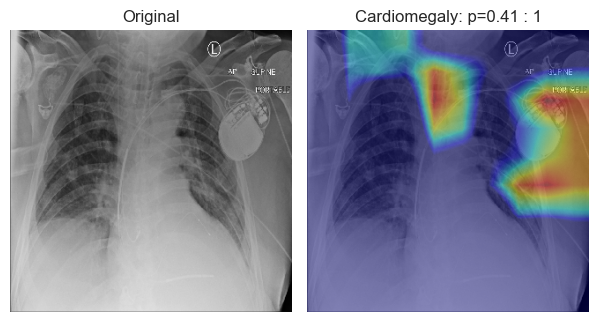

In [217]:
IMAGE_DIR = "LongTailCXR/images/"
#investigate how the model identifies Cardiomegaly

labels_to_show = ['Cardiomegaly']#np.take(labels, np.argsort(auc_rocs)[::-1])[:4]
img_file = '00000038_003.png' # Set the file name
compute_gradcam(model,img_file , IMAGE_DIR, data_sample, labels, labels_to_show)


In [211]:
test_data[(test_data['Infiltration'] == 1) & (test_data.iloc[:, 1:-1].sum(axis=1) == 1)]

,id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumoperitoneum,Pneumomediastinum,Subcutaneous Emphysema,Tortuous Aorta,Calcification of the Aorta,No Finding,subject_id
21,00000054_000.png,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,54
71,00000114_000.png,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,114
73,00000115_001.png,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,115
91,00000116_026.png,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,116
99,00000119_000.png,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15618,00020904_004.png,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,20904
15624,00020904_010.png,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,20904
15625,00020904_011.png,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,20904
15636,00020936_000.png,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,20936


1/1 [==============================] - 0s 360ms/step
Loading original image
Generating gradcam for class Infiltration


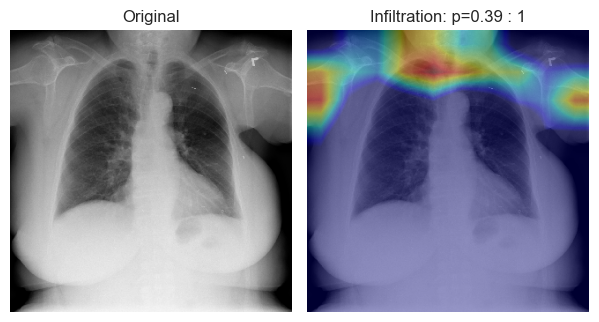

In [218]:
labels_to_show = ['Infiltration']
compute_gradcam(model,'00000054_000.png' , IMAGE_DIR, data_sample, labels, labels_to_show)

NB : An other way to compute GradCAM is to use directly  tf_explain package .

In [214]:
#investigate how the model identifies Cardiomegaly

index = 13 # refers to the id of an image that contains only Cardiomegaly
img, label = test_generator[index//8] # index//batch size : to get the number of batch containing the image
data = ([img[index%8]], None) #index% 8 : to get position of image inside the batch

# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, model, class_index=1)  # Cardiomecaly columns = index 1

explainer.save(grid, ".", "grad_cam_Cardiomegaly.png")

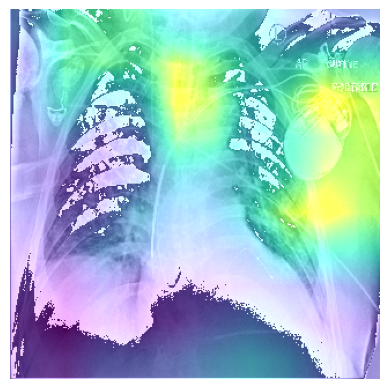

In [215]:
import matplotlib.image as mpimg

# Load the image file
img = mpimg.imread('grad_cam_Cardiomegaly.png')

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()